# Model Visualization


In [2]:
%matplotlib inline
import copy
from itertools import product
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mdp_lib.domains.gridworld import GridWorld
from planninginbeliefmodel import PlanningInObserverBeliefModel
from mdp_lib.domains.gridworldvis import visualize_trajectory, plot_text
from task import mdp_codes, mdp_params
from mdp_lib.util import sample_prob_dict
from util import mdp_to_feature_belief

path_to_sim_data = './cached_values/model_.pkl'
path_to_human_data = './cached_values/human_results.pkl'

In [22]:
def load_data(path):
    df = pd.read_pickle(path)
    df["rh"] = df["observer"].map(str) + '/' + df["demonstrator"]
    df["rh_mix"] = df["observer"].map(str) + '/' + df["demonstrator"]
    print(df.index)
    is_doing = df['demonstrator'] == 'doing'
    df_doing = df[is_doing].copy()
    print(len(df_doing.index))
    df_doing["rh_mix"] = df["observer"].map(str) + '/' + 'showing'
    df = df.append(df_doing, ignore_index=True)
    print(df.index)
    return df

# Plotting Doing (top row) versus Showing (bottom row) demonstrations

In [ ]:
fig, axes = plt.subplots(2, 8, figsize=(40, 10))

only_obs_judg = model_obs_judgments[model_obs_judgments['observer'] == 'naive']
gw = GridWorld(**mdp_params[0])

colors = ['r','b','k','g']
for (dtype, rf), block in only_obs_judg.groupby(['demonstrator', 'rf']):
    ax = axes[['doing', 'showing'].index(dtype)][mdp_codes.index(rf)]
    gw.plot(ax=ax, feature_colors={'o':'orange', 'p':'purple', 'c':'cyan'})
    
    ti = 0
    for _, row in block.iterrows():
        if row['demonstrator'] == 'showing':
            traj = row['traj'][:-1]
        else:
            traj = row['traj']
        visualize_trajectory(axis=ax, traj=traj, 
                             color=colors[ti % len(colors)])
        ti += 1
    ax.set_title(rf, fontsize=30)
plt.tight_layout()

# Demonstrator x Observer Correct Probability
This figure plots amount of probablity mass placed on the correct reward for a color (e.g. safe or dangerous) for each of the demonstrator and observer combinations.

In [4]:
sns.set_style('white')
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3.0})
sns.set_style({'lines.linewidth': 12, 'lines.markersize': 10, 
               'lines.markeredgewidth': 2, 'errorbar.capsize': 2,
               'axes.titlesize': 24
})

In [70]:
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Palatino"]})
rc("text", usetex = True)
rc("axes", **{"titlesize": 36, "labelsize": 30})
rc('text', usetex = True)

In [13]:
def plot_data(data, title='', filename=None, mixture=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    if mixture:
        x = 'rh_mix'
    else:
        x = 'rh'
    g = sns.barplot(data=data,
                    y='correct', x=x,
                    order=['sophisticated/showing', 'naive/showing', 'naive/doing', 'sophisticated/doing'],
                    #hue='demonstrator', hue_order=['doing', 'showing'],
                    palette=sns.light_palette("#60049F", reverse=True)[1:],
                    capsize=.05, errwidth=2, ax=ax)
    plt.ylim(.5, 1.02)
    g.set(yticks=[.5, .75, 1.0])
    ax.set_ylabel('Accuracy of Inferred Reward')
    ax.set_xticklabels(['Pedagogic $\mathbf{R}$ \n Pedagogic $\mathbf{H}$', 
                            'Literal $\mathbf{R}$ \n Pedagogic $\mathbf{H}$',
                            'Literal $\mathbf{R}$ \n Literal $\mathbf{H}$',
                            'Pedagogic $\mathbf{R}$ \n Literal $\mathbf{H}$'
                           ])
    ax.set_xlabel('Robot/Human Pairs', labelpad=12)
    ax.set_title(title)
    if filename is not None:
        fig.savefig('/Users/smitha/proj/ml/human_misspec/figs/pedagogy/{0}.pdf'.format(filename))

In [86]:
def plot_mixture(data, mixtures, title='', filename=None):
    lit_robot_accs = []
    lit_human_accs = []
    pp_acc = data[data['rh'] == 'sophisticated/showing']['correct'].mean()
    pl_acc = data[data['rh'] == 'sophisticated/doing']['correct'].mean()
    lp_acc = data[data['rh'] == 'naive/showing']['correct'].mean()
    ll_acc = data[data['rh'] == 'naive/doing']['correct'].mean()
    print(pp_acc, pl_acc, lp_acc, ll_acc)
    literal_accs = []
    pedagogic_accs = []
    for mixture_prob in mixtures:
        literal_acc = ll_acc*(1-mixture_prob) + lp_acc*mixture_prob
        ped_acc = pl_acc*(1-mixture_prob) + pp_acc*mixture_prob
        literal_accs.append(literal_acc)
        pedagogic_accs.append(ped_acc)
    fig = plt.figure()
    fig.set_size_inches((10, 10))
    plt.plot(mixtures, literal_accs, label='Literal Robot', marker='o', markerfacecolor='white')
    plt.plot(mixtures, pedagogic_accs, label='Pedagogic Robot', marker='o', markerfacecolor='white')
    plt.axvline(x=0.5, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)
    plt.legend()
    plt.ylabel('Accuracy')
    plt.xticks([0, 0.25, 0.5, 0.75, 1], [0, 0.25, r'$\alpha^*$ = 0.5', 0.75, 1])
    plt.xlabel('Probability of Being Pedagogic (' + r'$\alpha$' + ')')
    plt.title(title)
    if filename is not None:
        fig.savefig('/Users/smitha/proj/ml/human_misspec/figs/pedagogy/{0}.pdf'.format(filename))

(1.0, 0.6820833333333334, 0.8395833333333333, 0.8254166666666667)


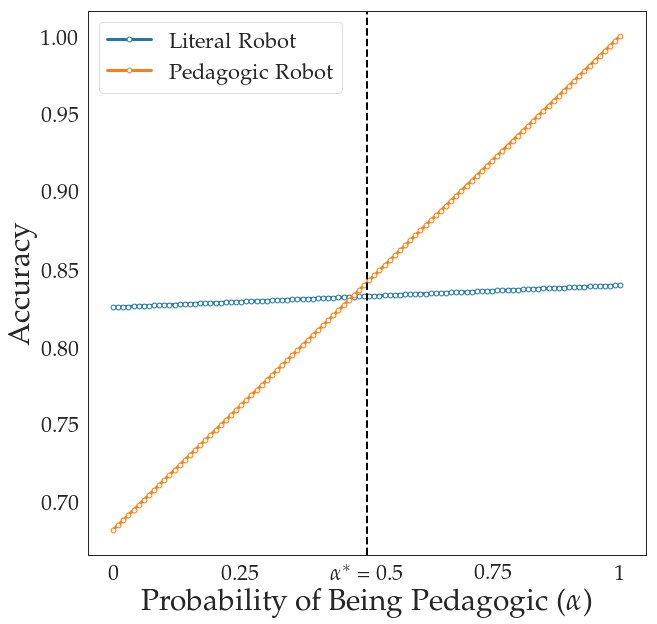

In [89]:
plot_mixture(sim_data, np.linspace(0, 1, 100), 'Simulations from Mixture Model', 'mixture')

In [23]:
sim_data = load_data(path_to_sim_data)

RangeIndex(start=0, stop=9600, step=1)
4800
RangeIndex(start=0, stop=14400, step=1)


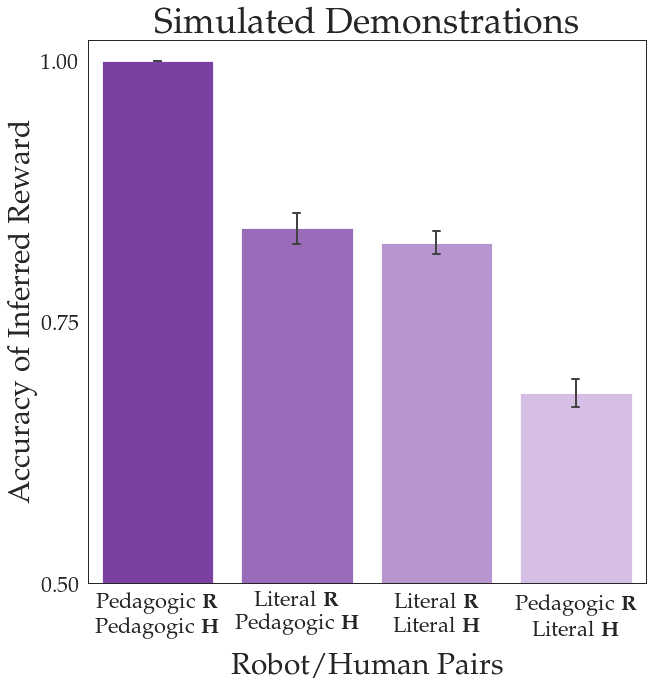

In [84]:
plot_data(sim_data, title='Simulated Demonstrations', filename='sim_results')

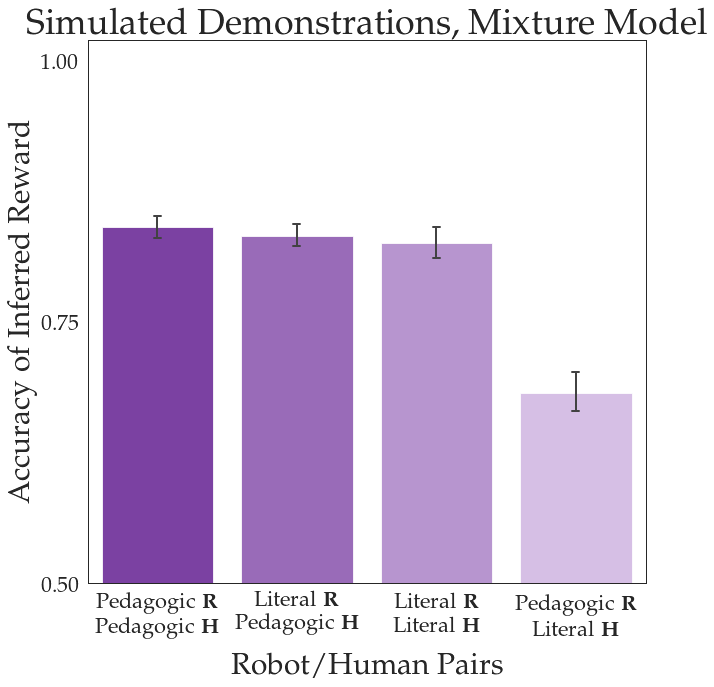

In [82]:
plot_data(sim_data, title='Simulated Demonstrations, Mixture Model', filename='sim_mixture_results', mixture=True)

In [91]:
human_data = load_data(path_to_human_data)

RangeIndex(start=0, stop=2784, step=1)
1392
RangeIndex(start=0, stop=4176, step=1)


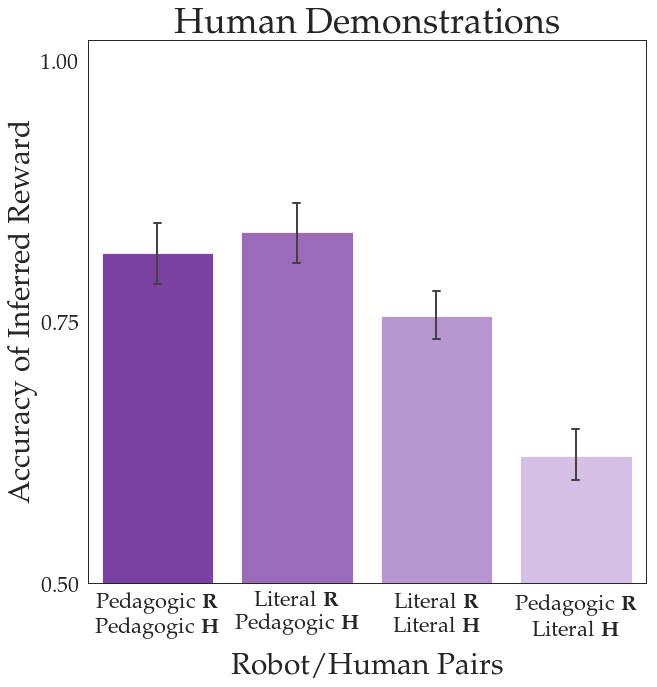

In [92]:
plot_data(human_data, title='Human Demonstrations', filename='human_results', mixture=False)

# Likelihood and Posterior Prob

In [ ]:
def plot_ll(ylabel='', filename=None):
    # Following values are calculated in Model_Simulations notebook
    data = [{'human': 'literal', 'Human Model': 'Literal', 'll': 21.11288195803672},
            {'human': 'literal', 'Human Model': 'Pedagogic', 'll': 28.0774046726638},
            {'human': 'pedagogic', 'Human Model': 'Literal', 'll': 42.99551940614264},
            {'human': 'pedagogic', 'Human Model': 'Pedagogic', 'll': 26.92586380495133}]
    data = pd.DataFrame(data)
    print(data)
    fig, ax = plt.subplots(figsize=(10, 10))
    g = sns.barplot(data=data,
                    y='ll', x='human',
                    order=['literal', 'pedagogic'],
                    hue='Human Model', hue_order=['Literal', 'Pedagogic'],
                    palette=['#4852CF', sns.light_palette("#60049F", reverse=True)[1]],
                    capsize=.05, errwidth=2, ax=ax)
    #plt.ylim(.5, 1.02)
    #g.set(yticks=[.5, .75, 1.0])
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(['Literal Human', 'Pedagogic Human'])
    ax.set_xlabel('Actual Human Type', labelpad=12)
    #ax.set_title(title)
    if filename is not None:
        fig.savefig('/Users/smitha/proj/ml/human_misspec/figs/pedagogy/{0}.pdf'.format(filename))

In [ ]:
plot_ll('Mean Negative Log-Likelihood', 'll')

In [ ]:
def calc_pp(data):
    pp = {
        'doing': {'naive': 0, 'sophisticated': 0}, 
        'showing': {'naive': 0, 'sophisticated': 0}
    }
    for index, row in data.iterrows():
        if row['correct_prob'] == 0:
            print(row['observer'])
            continue
        try:
            log_pp = np.log(row['correct_prob'])
            pp[row['demonstrator']][row['observer']] += -log_pp
        except:
            print(row['correct_prob'])
    return pp

# Beliefs over time
This plot compares the evolution of beliefs over time between the two observer interpretation models.

In [ ]:
plot_rf = 'oox'
plot_demonstrator = 'doing'
plot_i = 0

In [ ]:
belief_trajs = model_obs_judgments[['demonstrator', 'rf', 'traj',
                                    'observer', 'belief_traj', ]]
belief_trajs.traj = belief_trajs.traj.apply(tuple)
belief_trajs = belief_trajs.drop_duplicates(['demonstrator', 'rf', 'traj', 'observer'])
traj_block = belief_trajs[(belief_trajs.rf == plot_rf) & 
                          (belief_trajs.demonstrator == plot_demonstrator)]
wtraj = traj_block.traj.iloc[0]
traj_block = traj_block[traj_block.traj == wtraj]
obs_b = traj_block[traj_block.observer == 'naive'].iloc[plot_i]['belief_traj']
sobs_b = traj_block[traj_block.observer == 'sophisticated'].iloc[plot_i]['belief_traj']

forder = ['orange', 'purple', 'cyan']
obs_b = pd.DataFrame([mdp_to_feature_belief(b, mdp_codes, forder) for b in obs_b])
obs_b['step'] = obs_b.index
obs_b['observer'] = 'naive'
sobs_b = pd.DataFrame([mdp_to_feature_belief(b, mdp_codes, forder) for b in sobs_b])
sobs_b['step'] = sobs_b.index
sobs_b['observer'] = 'sophisticated'

b_trajs = pd.concat([obs_b, sobs_b])
b_trajs = pd.melt(b_trajs, id_vars=['step', 'observer'], 
                  value_vars=['cyan', 'orange', 'purple'],
                  value_name='exp_safe', var_name='color')

In [ ]:
ax = gw.plot(feature_colors={'o': 'orange', 'p': 'purple', 'c': 'cyan'})
visualize_trajectory(axis=ax, traj=wtraj[:-1])
sns.factorplot(data=b_trajs, x='step', y='exp_safe',
               hue='color', 
               palette={'cyan':'cyan', 'orange':'orange', 'purple':'purple'},
               col='observer', col_order=['naive', 'sophisticated'])